In [1]:
from dolo import *

In [2]:
model = yaml_import('krusell_smith.yaml')

    calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [3]:
import numpy as np
ub = 0.1
ug = 0.04
ub_dur = 2.5
ug_dur = 1.5
z_dur = 8
alpha = 0.36
A = 1
N = 1
delta = 0.025

def r(K,z):
    return A*alpha*z*(N/K)**(1-alpha)
def w(K,z):
    return A*(1-alpha)*z*(K/N)**(alpha)

In [4]:
#Transitions for (z,e)

p_gg = 1-1/z_dur
p_bb = 1-1/z_dur
p_gb = 1-p_gg
p_bg = 1-p_bb  

p00_gg = 1-1/ug_dur
p00_bb = 1-1/ub_dur
p01_gg = 1-p00_gg
p01_bb = 1-p00_bb

p00_gb= 1.25*p00_bb*p_gb/p_bb
p00_bg = 0.75*p00_gg*p_bg/p_gg
p01_gb = 1-p00_gb
p01_bg = 1-p00_bg

p10_gg = (ug*p_gg - ug*p00_gg)/(1-ug)
p10_bb = (ub*p_bb - ub*p00_bb)/(1-ub)
p10_gb = (ub*p_gb - ug*p00_gb)/(1-ug)
p10_bg = (ug*p_bg - ub*p00_bg)/(1-ub)
p11_gg = 1-p10_gg
p11_bb = 1-p10_bb
p11_gb = 1-p10_gb
p11_bg = 1-p10_bg

n_e = 2
n_z = 2


P_z = np.array([[p_bb,p_bg],[p_gb,p_gg]])

P_e = np.array([np.zeros((n_e,n_e))]*4)
P_e[0] = np.array([[p00_bb,p01_bb],[p10_bb,p11_bb]])
P_e[1] = np.array([[p00_bg,p01_bg],[p10_bg,p11_bg]])
P_e[2] = np.array([[p00_gb,p01_gb],[p10_gb,p11_gb]])
P_e[3] = np.array([[p00_gg,p01_gg],[p10_gg,p11_gg]])

P_z_e = np.array([[p_bb*p00_bb,p_bb*p01_bb,p_bg*p00_bg,p_bg*p01_bg],
           [p_bb*p10_bb,p_bb*p11_bb,p_bg*p10_bg,p_bg*p11_bg],
           [p_gb*p00_gb,p_gb*p01_gb,p_gg*p00_gg,p_gg*p01_gg],
           [p_gb*p10_bb,p_gb*p11_bb,p_gg*p10_gg,p_gg*p11_gg]])

#Transitions for (r,w,e)
n_K = 2
K_min = 10.
K_max = 15.
grid_K = np.linspace(K_min,K_max,n_K) #Grid for aggregate capital
from scipy.linalg import block_diag
Gamma = block_diag(*([P_z]*n_K)) #No change in aggregate capital


transitions = np.zeros((n_K*n_z*n_e,n_K*n_z*n_e))
for i_K in range(n_K):
        for i_z in range(n_z):
            for i_K_next in range(n_K):
                for i_z_next in range(n_z):
                    for i_e in range(n_e):
                        for i_e_next in range(n_e):
                            ind = i_K*n_z*n_e + i_z*n_e + i_e
                            fin = i_K_next*n_z*n_e + i_z_next*n_e + i_e_next
                            transitions[ind,fin] = Gamma[i_K*n_z + i_z,i_K_next*n_z + i_z_next]*P_e[i_z*n_z+i_z_next][i_e,i_e_next]

#Values for (r,w,e)

grid_z = [0.99,1.01]
grid_e = [0., 1.]
values = np.zeros((transitions.shape[0], len(model.symbols['exogenous'])))
for i_K in range(n_K):
    K = grid_K[i_K]
    for i_z in range(n_z):
        z = grid_z[i_z]
        for i_e in range(n_e):
            e = grid_e[i_e]
            values[i_K*n_e*n_z + i_z*n_e + i_e,:] = [r(K,z),w(K,z),e]

In [5]:
from dolo.numeric.processes import DiscreteMarkovProcess
dprocs = DiscreteMarkovProcess(transitions,values)

In [6]:
sol = improved_time_iteration(model, dp=dprocs, verbose=True)

------------------------------------------------------------------------------------------------------
| Start Improved Time Iterations.                                                                    |
------------------------------------------------------------------------------------------------------
| N    | f_x       | d_x       | Time_residuals | Time_inversion | Time_search | Lambda_0  | N_invert | N_search |
------------------------------------------------------------------------------------------------------
|    0 | 8.948e+00 | 6.505e-01 | 2.520e+00 | 3.700e-01 | 1.000e-02 | 6.473e-01 |       32 |        0 |
|    1 | 7.922e+00 | 1.028e+00 | 5.000e-02 | 7.000e-02 | 1.000e-02 | 6.208e-01 |       34 |        0 |
|    2 | 2.616e+00 | 3.194e+00 | 5.000e-02 | 9.000e-02 | 2.000e-02 | 6.573e-01 |       43 |        1 |
|    3 | 1.771e+00 | 5.283e+00 | 4.000e-02 | 8.000e-02 | 3.000e-02 | 5.710e-01 |       36 |        1 |
|    4 | 1.242e+00 | 7.334e+00 | 5.000e-02 | 8.000e-02 | 3.00

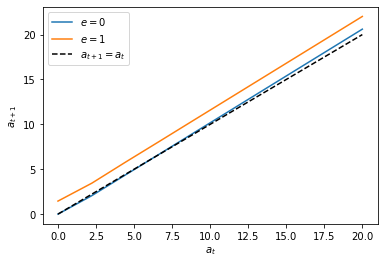

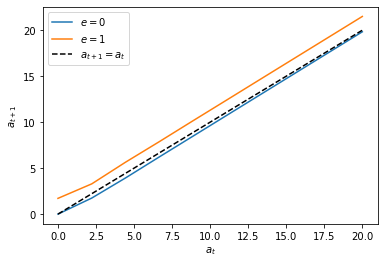

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(sol.dr.endo_grid.nodes,sol.dr(0,sol.dr.endo_grid.nodes))
plt.plot(sol.dr.endo_grid.nodes,sol.dr(1,sol.dr.endo_grid.nodes))
plt.plot(sol.dr.endo_grid.nodes,sol.dr.endo_grid.nodes,'k--')
plt.xlabel("$a_t$")
plt.ylabel("$a_{t+1}$")
plt.legend(["$e = 0$","$e = 1$","$a_{t+1} = a_{t}$"])

plt.figure()
plt.plot(sol.dr.endo_grid.nodes,sol.dr(n_K*n_z*n_e-2,sol.dr.endo_grid.nodes))
plt.plot(sol.dr.endo_grid.nodes,sol.dr(n_K*n_z*n_e-1,sol.dr.endo_grid.nodes))
plt.plot(sol.dr.endo_grid.nodes,sol.dr.endo_grid.nodes,'k--')
plt.xlabel("$a_t$")
plt.ylabel("$a_{t+1}$")
plt.legend(["$e = 0$","$e = 1$","$a_{t+1} = a_{t}$"])

In [8]:
def find_last(x,l):
    '''Finds the index i of a sorted list such that l[i] < x <= l[i+1]'''
    if l.size == 0:
        return -1
    else:
        h = l[0]
        t = l[1:]
        if h < x:
            return 1+find_last(x,t)
        else:
            return 0

import numpy as np

def MarkovErgodic( A ):
    """ x = xA where x is the answer
    x - xA = 0
    x( I - A ) = 0 and sum(x) = 1
    """
    n = A.shape[0]
    a = np.eye( n ) - A
    a = np.vstack( (a.T, np.ones( n )) )
    b = np.array( [0] * n + [ 1 ] ).T
    return np.linalg.lstsq( a, b )[0]

def MarkovPolicy(sol):
    """
    Computes the Markov transmission matrix associated with the decision rule sol
    """
    n_s = sol.dr.endo_grid.n[0]
    n_m = sol.dr.exo_grid.__nodes__.shape[0]
    P = sol.dr.dprocess.transitions
    n = n_m*n_s
    Q = np.zeros((n,n))
    for i_m_s in range(n):
        i_s = i_m_s % n_s
        i_m = (i_m_s-i_s) // n_s
        i_s_next = find_last(sol.dr.coefficients[i_m][1+i_s], sol.dr.endo_grid.__nodes__)
        for i_m_next in range(n_m):
            Q[i_m_s,i_m_next*n_s + i_s_next] += P[i_m,i_m_next]
        Q[i_m_s,:] /= np.sum(Q[i_m_s,:]) 
    return Q

In [9]:
def UpdateTransitions(sol,Gamma,P_z,P_e,grid_K,n_K,n_z,n_e):
    """
    Updates the Markov transition matrix of exogenous variables
    """
    transitions = np.zeros((n_K*n_z*n_e,n_K*n_z*n_e))
    for i_K in range(n_K):
        for i_z in range(n_z):
            for i_K_next in range(n_K):
                for i_z_next in range(n_z):
                    ind = i_K*n_z*n_e + i_z*n_e
                    fin = i_K_next*n_z*n_e + i_z_next*n_e
                    transitions[ind:ind+n_e,fin:fin+n_e] = Gamma[i_K*n_z + i_z,i_K_next*n_z + i_z_next]*P_e[i_z*n_z+i_z_next]
    return transitions

In [10]:
def UpdateGamma(sol,P_z,grid_K,n_K,n_z,n_e):
    """
    Computes the law of motion of aggregate capital
    """
    Q = MarkovPolicy(sol)
    distr = MarkovErgodic(Q)
    grid_a = sol.dr.endo_grid.__nodes__
    n_s = grid_a.shape[0]
    distr_K_z = np.zeros((n_K,n_z))

    for i_K in range(n_K):
        for i_z in range(n_z):
            distr_K_z[i_K,i_z] += np.sum(distr[i_K*n_z*n_e*n_s + i_z*n_e*n_s:i_K*n_z*n_e*n_s + i_z*n_e*n_s + n_e*n_s])
    distr_z = np.sum(distr_K_z,axis=0)
    
    grid_a_e = np.vstack([grid_a]*n_e)
    UpdatedGamma = np.zeros((n_K*n_z,n_K*n_z))

    K_next = np.zeros((n_K*n_z*n_e*n_s,n_z))

    for i_z_next in range(n_z):
        pol_a = 0.
        for i_K_next in range(n_K):

            fin_lb = i_K_next*n_z*n_e*n_s + i_z_next*n_e*n_s
            fin_ub = i_K_next*n_z*n_e*n_s + (i_z_next+1)*n_e*n_s
            pol_a += (Q[:,fin_lb:fin_ub] @ grid_a_e)/distr_z[i_z_next]

        K_next[:,i_z_next] = pol_a[:,0]

    for i_K in range(n_K):
        for i_z in range(n_z):
            for i_z_next in range(n_z):

                p = K_next[i_K*n_z*n_e*n_s+i_z*n_e*n_s:i_K*n_z*n_e*n_s+i_z*n_e*n_s+n_e*n_s,i_z_next]
                d = distr[i_K*n_z*n_e*n_s+i_z*n_e*n_s:i_K*n_z*n_e*n_s+i_z*n_e*n_s+n_e*n_s]

                i_K_next = find_last((p @ d)/distr_K_z[i_K,i_z], grid_K)
                UpdatedGamma[i_K*n_z + i_z,i_K_next*n_z + i_z_next] = P_z[i_z,i_z_next]
    
    return UpdatedGamma

In [11]:
import time
tol = 1e-9
adj = 1.
s=sol
dist = 1e10
iter = 0
iter_max = 100

In [12]:
t1 = time.time()
while (dist > tol) and (iter < iter_max) :
    
    dprocs = DiscreteMarkovProcess(transitions,values)
       
    s = improved_time_iteration(model, dp=dprocs, verbose=True)
    
    UpdatedGamma = UpdateGamma(s,P_z,grid_K,n_K,n_z,n_e)
    dist = np.amax(np.abs(UpdatedGamma - Gamma))
    
    Gamma = adj*UpdatedGamma + (1-adj)*Gamma
    transitions = UpdateTransitions(s,Gamma,P_z,P_e,grid_K,n_K,n_z,n_e)
    print(Gamma)
    iter += 1

    print("Iteration ",iter," : ", dist)
t2 = time.time()
print("Elapsed: {} seconds.".format(t2-t1))

------------------------------------------------------------------------------------------------------
| Start Improved Time Iterations.                                                                    |
------------------------------------------------------------------------------------------------------
| N    | f_x       | d_x       | Time_residuals | Time_inversion | Time_search | Lambda_0  | N_invert | N_search |
------------------------------------------------------------------------------------------------------
|    0 | 8.948e+00 | 6.505e-01 | 5.000e-02 | 7.000e-02 | 1.000e-02 | 6.473e-01 |       32 |        0 |
|    1 | 7.922e+00 | 1.028e+00 | 5.000e-02 | 7.000e-02 | 1.000e-02 | 6.208e-01 |       34 |        0 |
|    2 | 2.616e+00 | 3.194e+00 | 5.000e-02 | 9.000e-02 | 2.000e-02 | 6.573e-01 |       43 |        1 |
|    3 | 1.771e+00 | 5.283e+00 | 5.000e-02 | 8.000e-02 | 2.000e-02 | 5.710e-01 |       36 |        1 |
|    4 | 1.242e+00 | 7.334e+00 | 4.000e-02 | 9.000e-02 | 2.00

    `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.    0.125 0.875 0.   ]
 [0.125 0.    0.    0.875]
 [0.    0.125 0.875 0.   ]
 [0.125 0.    0.    0.875]]
Iteration  1  :  0.875
------------------------------------------------------------------------------------------------------
| Start Improved Time Iterations.                                                                    |
------------------------------------------------------------------------------------------------------
| N    | f_x       | d_x       | Time_residuals | Time_inversion | Time_search | Lambda_0  | N_invert | N_search |
------------------------------------------------------------------------------------------------------
|    0 | 9.007e+00 | 6.513e-01 | 7.700e-02 | 6.600e-02 | 1.600e-02 | 5.614e-01 |       27 |        0 |
|    1 | 8.007e+00 | 1.023e+00 | 7.300e-02 | 4.000e-02 | 1.000e-02 | 2.889e-01 |       15 |        0 |
|    2 | 2.748e+00 | 2.032e+00 | 4.000e-02 | 1.000e-01 | 1.000e-02 | 6.593e-01 |       43 |        0 |
|    3 | 1.474e+00 | 6.165e+00 |